In [35]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load data
df = pd.read_csv("/Users/shubhamgandhi/Desktop/aml/Churn-Prediction/preprocessed_with_smote.csv")

# Separate features and target
target = df['Exited']
features = df.drop('Exited', axis=1)

# Convert to NumPy arrays
X = features.to_numpy()
y = target.to_numpy()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree Implementation
class OptimizedDecisionTree:
    """
    A more efficient implementation of a regression tree for Gradient Boosting.
    """

    def __init__(self, max_depth=3, min_samples_split=2, num_thresholds=10):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.num_thresholds = num_thresholds  # Limit thresholds for efficiency
        self.tree = None

    def fit(self, X, y, depth=0):
        """
        Recursively build the tree by splitting on features to minimize variance.
        """
        n_samples, n_features = X.shape
        # Stopping conditions: maximum depth reached or not enough samples to split
        if depth == self.max_depth or n_samples < self.min_samples_split:
            return np.mean(y)  # Return leaf value (mean of target values)
        
        best_split = self.find_best_split(X, y, n_features)
        if not best_split:
            return np.mean(y)  # No valid split found, return leaf value
        
        feature, threshold, left_idx, right_idx = best_split
        left_tree = self.fit(X[left_idx], y[left_idx], depth + 1)
        right_tree = self.fit(X[right_idx], y[right_idx], depth + 1)
        
        return {"feature": feature, "threshold": threshold, "left": left_tree, "right": right_tree}

    def find_best_split(self, X, y, n_features):
        """
        Find the best split for a node by minimizing residual variance.
        Optimize by reducing the number of thresholds tested.
        """
        best_feature, best_threshold = None, None
        best_variance = float("inf")
        best_left_idx, best_right_idx = None, None

        for feature in range(n_features):
            feature_values = X[:, feature]
            # Use percentiles to reduce threshold candidates
            thresholds = np.percentile(feature_values, np.linspace(0, 100, self.num_thresholds))
            for threshold in thresholds:
                left_idx = feature_values <= threshold
                right_idx = feature_values > threshold
                if np.sum(left_idx) == 0 or np.sum(right_idx) == 0:
                    continue
                
                left_variance = np.var(y[left_idx]) * np.sum(left_idx)
                right_variance = np.var(y[right_idx]) * np.sum(right_idx)
                total_variance = left_variance + right_variance

                if total_variance < best_variance:
                    best_variance = total_variance
                    best_feature = feature
                    best_threshold = threshold
                    best_left_idx = left_idx
                    best_right_idx = right_idx

        if best_feature is None:
            return None  # No valid split found
        
        return best_feature, best_threshold, best_left_idx, best_right_idx

    def predict_single(self, x, tree):
        """
        Predict the target value for a single sample by traversing the tree.
        """
        if not isinstance(tree, dict):  # Leaf node
            return tree

        feature = tree["feature"]
        threshold = tree["threshold"]
        if x[feature] <= threshold:
            return self.predict_single(x, tree["left"])
        else:
            return self.predict_single(x, tree["right"])

    def predict(self, X):
        """
        Predict target values for all samples.
        """
        return np.array([self.predict_single(x, self.tree) for x in X])

    def fit_and_predict(self, X, y):
        """
        Fit the tree and set it as the current model and return predictions.
        """
        self.tree = self.fit(X, y)
        return self.predict(X)


# Gradient Boosting Implementation
n_estimators = 100  # Number of boosting rounds
learning_rate = 0.01  # Learning rate
manual_trees = []

# Initialize predictions with the mean of the target variable (for the training set)
initial_prediction = np.mean(y_train)
train_predictions = np.full(len(y_train), initial_prediction)

# Boosting loop
for _ in range(n_estimators):
    # Compute residuals (negative gradient for MSE)
    residuals = y_train - train_predictions

    # Fit an optimized regression tree to the residuals
    tree = OptimizedDecisionTree(max_depth=2, num_thresholds=10)
    tree.tree = tree.fit(X_train, residuals)
    manual_trees.append(tree)

    # Update predictions with scaled tree predictions
    train_predictions += learning_rate * tree.predict(X_train)

# Final prediction on test data
test_predictions = np.full(len(y_test), initial_prediction)
for tree in manual_trees:
    test_predictions += learning_rate * tree.predict(X_test)

# Convert predictions to binary (0/1) using 0.5 as the threshold
test_predictions_binary = (test_predictions >= 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, test_predictions_binary)
print(f"Gradient Boosting Accuracy: {accuracy:.2f}")

Gradient Boosting Accuracy: 0.73


In [37]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.70      0.73      1633
           1       0.71      0.75      0.73      1553

    accuracy                           0.73      3186
   macro avg       0.73      0.73      0.73      3186
weighted avg       0.73      0.73      0.73      3186


Confusion Matrix:
[[1147  486]
 [ 381 1172]]

ROC-AUC Score: 0.73


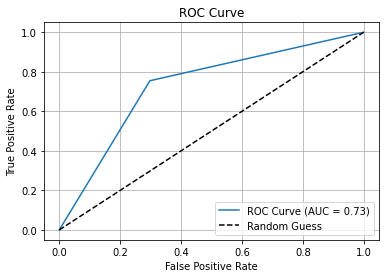

In [38]:
print("\nClassification Report:")
print(classification_report(y_test, test_predictions_binary))

conf_matrix = confusion_matrix(y_test, test_predictions_binary)
print("\nConfusion Matrix:")
print(conf_matrix)

# ROC-AUC Score (Only valid for binary classification)
if len(np.unique(y_test)) == 2:
    gb_roc_auc = roc_auc_score(y_test, test_predictions_binary)
    print(f"\nROC-AUC Score: {gb_roc_auc:.2f}")

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, test_predictions_binary)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {gb_roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
else:
    print("\nROC-AUC Score is not applicable for non-binary classification.")